# Time Series Project - BBQ Sauce Sales 2020-2025

## Importing required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

## Uploading the data

In [198]:
#Upload the data

data = pd.read_csv(
    "barbecue_sauce_sales.csv",
    parse_dates=["date"],
    date_format="%m/%d/%Y"
)
print(" BBQ Sauce Sales Data Preview:")
display(data.head())

# Climate dataset
climate_data = pd.read_csv("climate_data.csv")
print("\n Climate Data Preview:")
display(climate_data.head())

 BBQ Sauce Sales Data Preview:


,date,amount
0,2020-01-03,285
1,2020-01-06,627
2,2020-01-07,241
3,2020-01-08,356
4,2020-01-09,877



 Climate Data Preview:


,date,mean_temp_nationwide,min_temp_nationwide,max_temp_nationwide,mean_precipitation_mm_nationwide,min_precipitation_mm_nationwide,max_precipitation_mm_nationwide,mean_sun_hours_nationwide,min_sun_hours_nationwide,max_sun_hours_nationwide
0,2020-01-03,5.24,3.3,7.8,2.61,0.7,6.6,0.577778,0.0,4.2
1,2020-01-06,3.07,-0.6,5.6,0.30,0.0,1.7,3.866667,0.0,8.2
2,2020-01-07,3.90,1.0,6.9,0.48,0.0,1.6,0.411111,0.0,1.4
3,2020-01-08,6.12,2.4,9.3,3.60,0.0,13.6,0.022222,0.0,0.2
4,2020-01-09,9.16,7.0,11.4,4.84,0.0,10.9,1.377778,0.0,7.6


## Basic Data Quality & Overview

In [167]:
# 1.1 Ensure correct types
# Convert 'amount' to numeric (coerce errors to NaN)
data['amount'] = pd.to_numeric(data['amount'], errors='coerce')

# Convert 'date' to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# 1.2 Sort by date and set index
data = data.sort_values('date')
data.set_index('date', inplace=True)



In [190]:
# 1.3 Check for missing values
print("Data Types & Non-Null Counts:")
print(data.info())
print("\n Missing Values by Column:")
print(data.isnull().sum())




Data Types & Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1386 entries, 2020-01-03 to 2025-07-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   amount  1386 non-null   int64
dtypes: int64(1)
memory usage: 53.9 KB
None

 Missing Values by Column:
amount    0
dtype: int64


In [ ]:
# 1.4. Mark duplicates only by date + amount
dupes_date_amount = data[data.duplicated(subset=['amount'], keep=False) & data.index.duplicated(keep=False)]
print("Number of duplicates with same date & amount:", dupes_date_amount.shape[0])



Number of duplicates with same date & amount: 0


In [ ]:
# 1.5 Summary statistics
print("\n Summary Statistics for 'amount':")
summary_stats = data['amount'].describe().round(2)
summary_stats['median'] = data['amount'].median()
summary_stats['25%'] = data['amount'].quantile(0.25)
summary_stats['50%'] = data['amount'].quantile(0.50)
summary_stats['75%'] = data['amount'].quantile(0.75)
print(summary_stats)




 Summary Statistics for 'amount':
count     1386.00
mean       483.37
std        859.92
min          0.00
25%         35.00
50%        105.00
75%        522.00
max       5703.00
median     105.00
Name: amount, dtype: float64


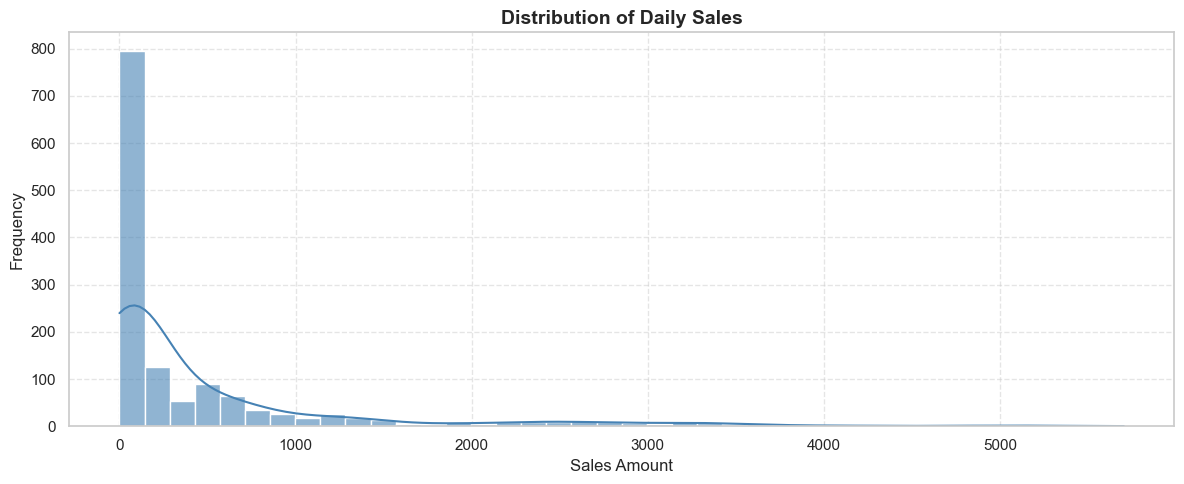

In [ ]:
# 1.6 Distribution Plots
sns.set_theme(style="whitegrid")

# Histogram + KDE
plt.figure(figsize=(12,5))
sns.histplot(data['amount'], bins=40, kde=True, color='steelblue', alpha=0.6)
plt.title("Distribution of Daily Sales", fontsize=14, weight='bold')
plt.xlabel("Sales Amount")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


The distribution of daily BBQ sauce sales is highly right-skewed, indicating that most days record low sales amounts while a few days experience exceptionally high sales. This suggests occasional sales spikes, possibly due to promotions, holidays, or seasonal demand patterns.

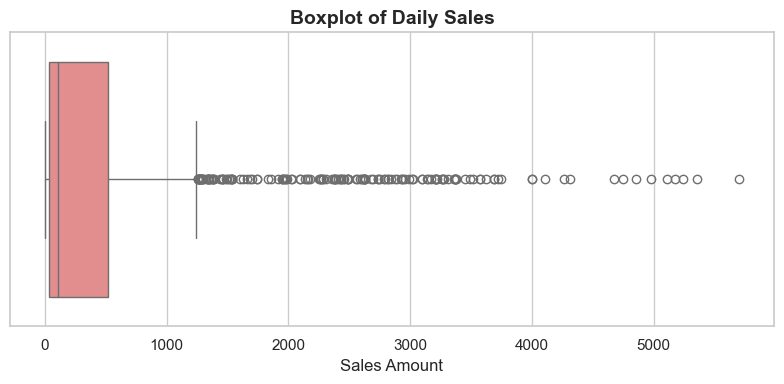

In [ ]:

# 1.7 Boxplot for outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=data['amount'], color='lightcoral')
plt.title("Boxplot of Daily Sales", fontsize=14, weight='bold')
plt.xlabel("Sales Amount")
plt.tight_layout()
plt.show()

The boxplot shows that most BBQ sauce sales are concentrated at lower values, with numerous high-value outliers extending beyond 1000 units.

## Exploratory Data Analysis

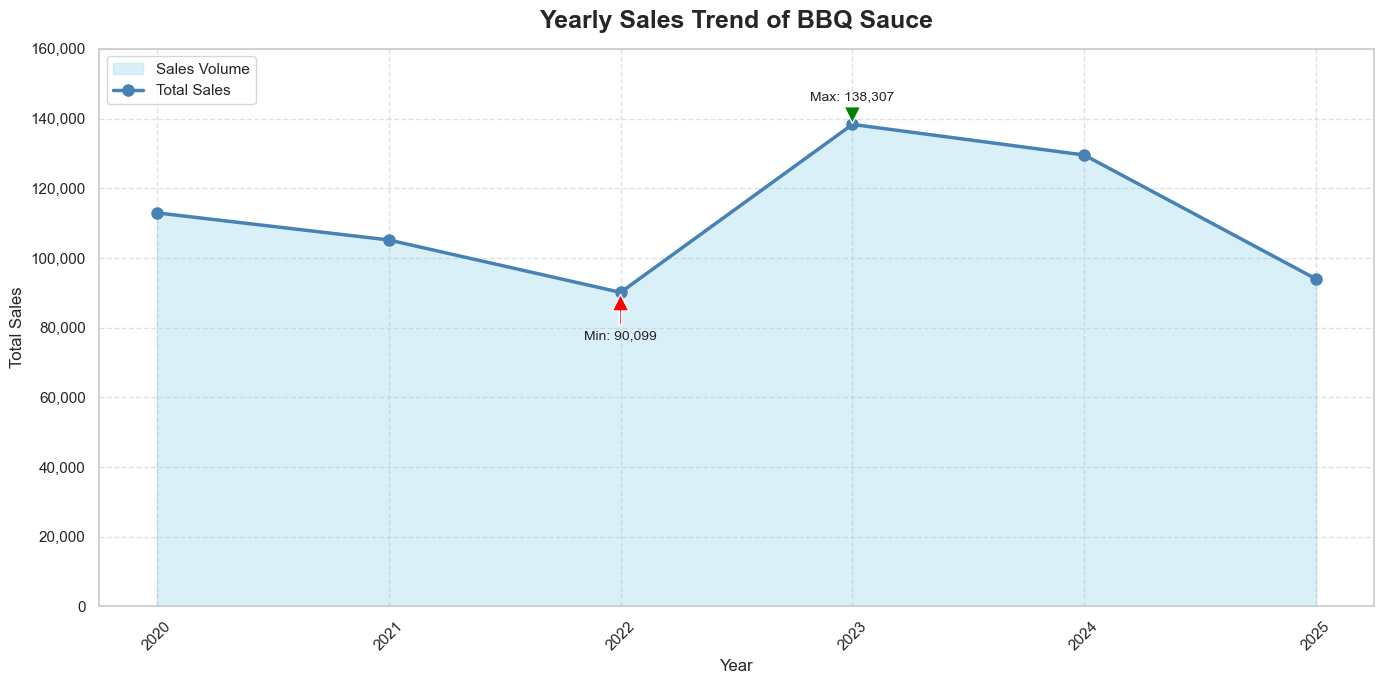

Yearly Sales Summary:
   year  amount
0  2020  112920
1  2021  105145
2  2022   90099
3  2023  138307
4  2024  129529
5  2025   93952


In [172]:
# Group sales by year
# Ensure index is DatetimeIndex 
data.index = pd.to_datetime(data.index)

sales_per_year = data.resample('Y')['amount'].sum().reset_index()
sales_per_year['year'] = sales_per_year['date'].dt.year

# Visualization settings 
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))

# Plot line and shaded area
plt.fill_between(
    sales_per_year['year'],
    sales_per_year['amount'],
    color='skyblue',
    alpha=0.3,
    label='Sales Volume'
)

plt.plot(
    sales_per_year['year'],
    sales_per_year['amount'],
    marker='o',
    markersize=8,
    linewidth=2.5,
    color='steelblue',
    label='Total Sales'
)

# Annotate max and min points 
max_idx = sales_per_year['amount'].idxmax()
min_idx = sales_per_year['amount'].idxmin()
max_year = sales_per_year.loc[max_idx, 'year']
max_value = sales_per_year.loc[max_idx, 'amount']
min_year = sales_per_year.loc[min_idx, 'year']
min_value = sales_per_year.loc[min_idx, 'amount']

plt.annotate(
    f'Max: {max_value:,.0f}',
    xy=(max_year, max_value),
    xytext=(max_year, max_value * 1.05),
    ha='center',
    fontsize=10,
    arrowprops=dict(facecolor='green', shrink=0.05, width=1.5)
)

plt.annotate(
    f'Min: {min_value:,.0f}',
    xy=(min_year, min_value),
    xytext=(min_year, min_value * 0.85),
    ha='center',
    fontsize=10,
    arrowprops=dict(facecolor='red', shrink=0.05, width=1.5)
)

# Titles & Labels
plt.title('Yearly Sales Trend of BBQ Sauce', fontsize=18, weight='bold', pad=15)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(sales_per_year['year'], rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Set Y-axis range
plt.ylim(0, 160000)

#  Style details 
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

# Print summary table
print("Yearly Sales Summary:")
print(sales_per_year[['year', 'amount']])


The graph shows total BBQ sauce sales from 2020 to 2025, with clear fluctuations. Sales fell between 2020 and 2022—likely due to COVID-19 restrictions limiting outdoor gatherings. A strong rebound occurred in 2023, fueled by post-pandemic recovery and favorable weather. In 2024, sales held steady. The apparent drop in 2025 reflects that the data only cover sales through July, which makes the year look incomplete.

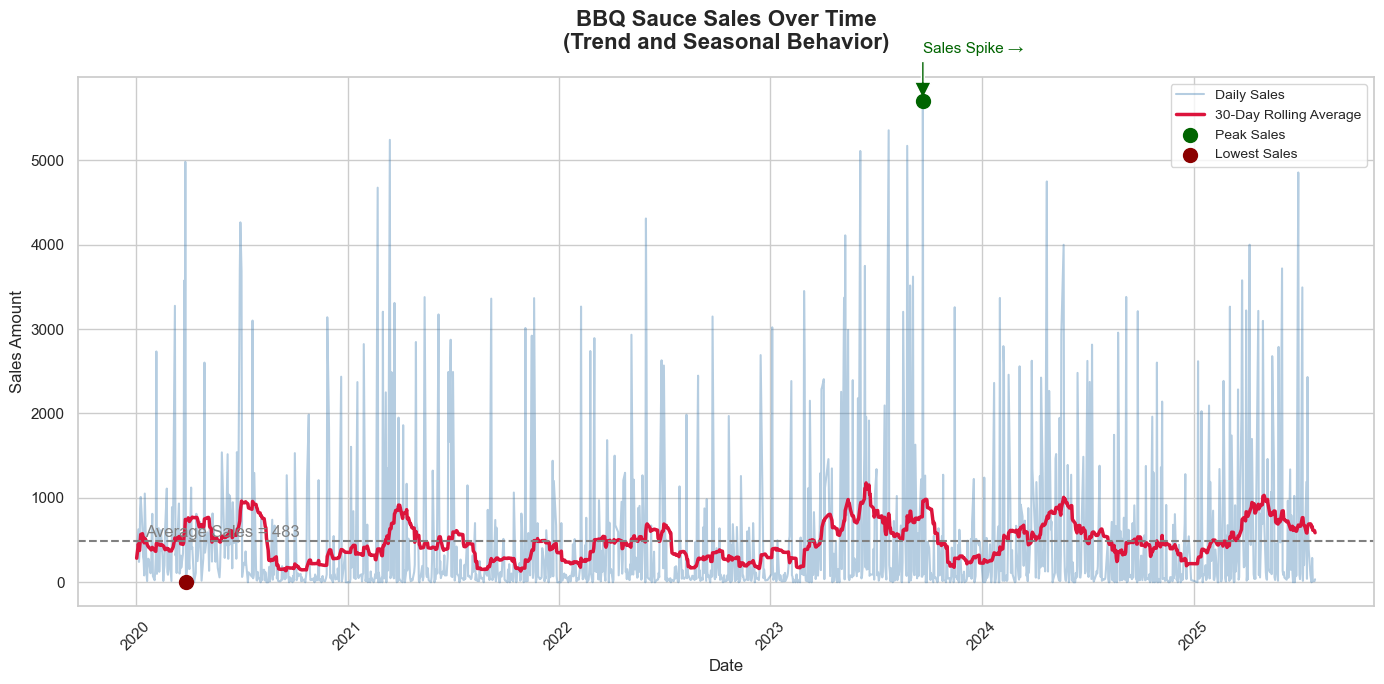

In [173]:
# Detailed Time Series Plot with Annotations

# Add a rolling mean (7-day or 30-day smoothing, depending on data frequency)
data['rolling_mean'] = data['amount'].rolling(window=30, min_periods=1).mean()

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

# Plot main time series
plt.plot(data.index, data['amount'], color='steelblue', alpha=0.4, label='Daily Sales')

# Add smoothed trend line
plt.plot(data.index, data['rolling_mean'], color='crimson', linewidth=2.5, label='30-Day Rolling Average')

# Highlight the maximum and minimum points
max_date = data['amount'].idxmax()
min_date = data['amount'].idxmin()
plt.scatter(max_date, data.loc[max_date, 'amount'], color='darkgreen', s=100, zorder=5, label='Peak Sales')
plt.scatter(min_date, data.loc[min_date, 'amount'], color='darkred', s=100, zorder=5, label='Lowest Sales')

# Add mean line
mean_sales = data['amount'].mean()
plt.axhline(y=mean_sales, color='gray', linestyle='--', linewidth=1.5)
plt.text(data.index[10], mean_sales + 50, f"Average Sales = {mean_sales:.0f}", color='gray')

# Annotations for storytelling
plt.annotate('Sales Spike →', xy=(max_date, data.loc[max_date, 'amount']),
             xytext=(max_date, data['amount'].max() * 1.1),
             arrowprops=dict(facecolor='darkgreen', shrink=0.05, width=2),
             fontsize=11, color='darkgreen')

# Title and labels
plt.title('BBQ Sauce Sales Over Time\n(Trend and Seasonal Behavior)', fontsize=16, weight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Amount', fontsize=12)

# Add legend
plt.legend(frameon=True, facecolor='white', fontsize=10)

# Rotate x-axis labels for clarity
plt.xticks(rotation=45)

# Tight layout for better spacing
plt.tight_layout()

plt.show()

The graph shows that BBQ sauce sales tend to rise and fall with the seasons, peaking around the middle of each year—likely during summer and holiday months. While there’s noticeable volatility, overall sales have gradually increased over time, with a major spike in 2023 standing out. The 30-day rolling average line smooths out the daily ups and downs, clearly showing repeating sales cycles and a steady upward trend in demand.

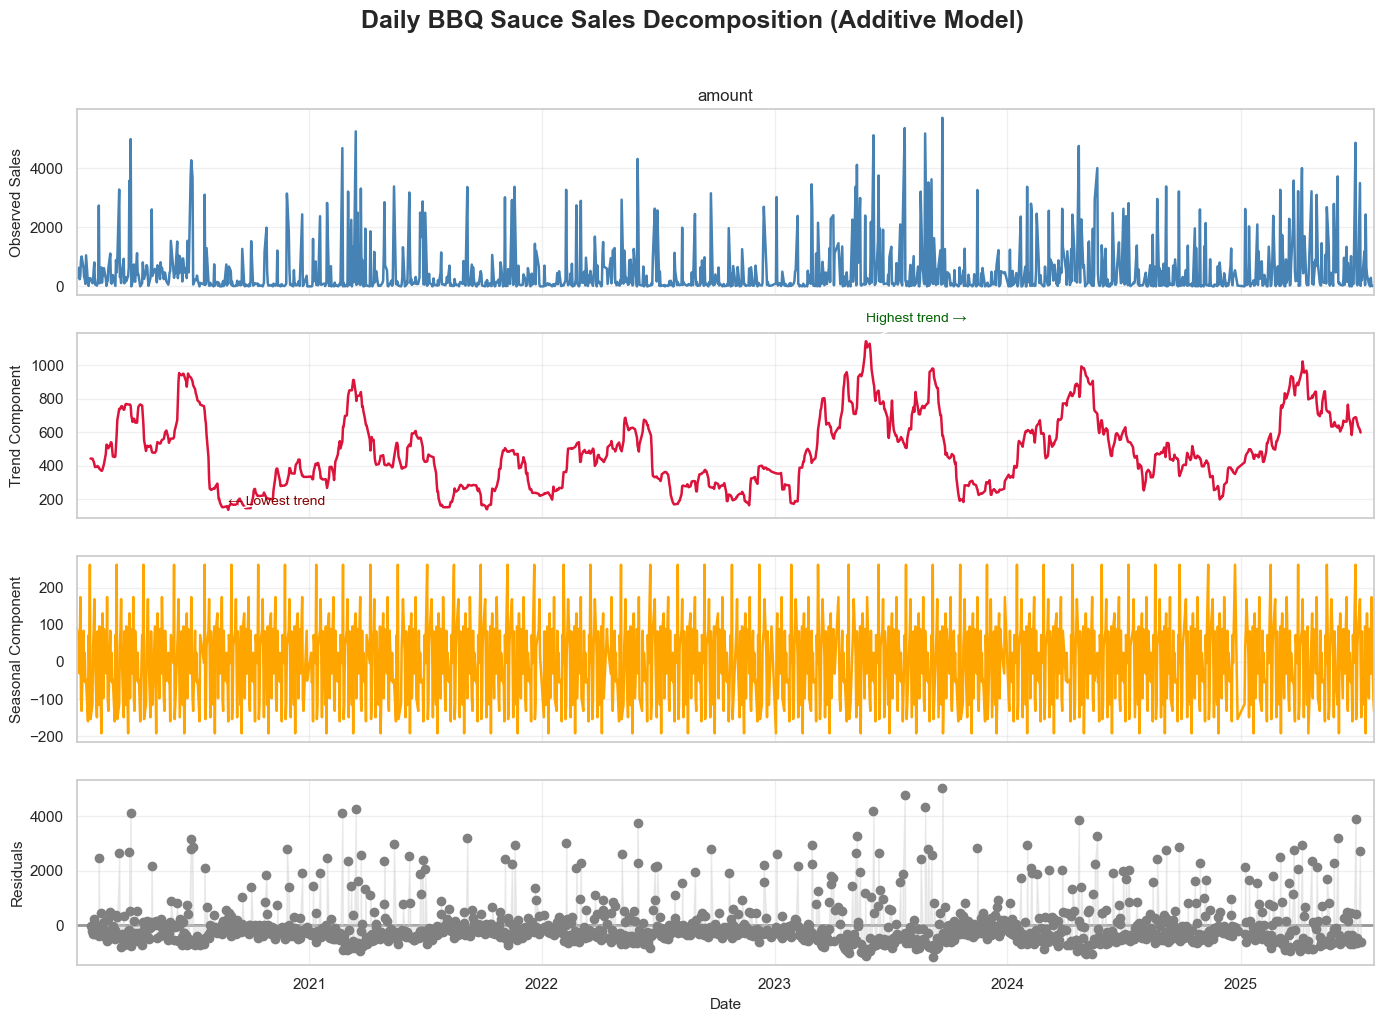

In [174]:

# Ensure index is datetime 
data.index = pd.to_datetime(data.index)
data = data.sort_index()


# 2. Perform decomposition

daily_decomp = seasonal_decompose(data['amount'], model='additive', period=30)


# 3. Set style and create plot

sns.set_style("whitegrid")
fig = daily_decomp.plot()
fig.set_size_inches(14, 10)


# 4. Titles and axis labels

fig.suptitle('Daily BBQ Sauce Sales Decomposition (Additive Model)', 
             fontsize=18, weight='bold', y=1.02)

ylabels = ['Observed Sales', 'Trend Component', 'Seasonal Component', 'Residuals']
for ax, ylabel in zip(fig.axes, ylabels):
    ax.set_ylabel(ylabel, fontsize=11)

fig.axes[3].set_xlabel('Date', fontsize=11)


# 5. Styling each subplot

colors = ['steelblue', 'crimson', 'orange', 'gray']
for ax, color in zip(fig.axes, colors):
    for line in ax.lines:
        line.set_color(color)
        line.set_linewidth(1.8)
    ax.grid(True, alpha=0.3)


# 6. Highlight residual variation

fig.axes[3].fill_between(
    data.index, 
    daily_decomp.resid, 
    color='lightgray', 
    alpha=0.4
)


# 7. Annotate key trend points

trend_series = daily_decomp.trend.dropna()
if not trend_series.empty:
    max_trend_date = trend_series.idxmax()
    min_trend_date = trend_series.idxmin()

    fig.axes[1].annotate('Highest trend →', 
                         xy=(max_trend_date, trend_series.max()), 
                         xytext=(max_trend_date, trend_series.max() * 1.1),
                         arrowprops=dict(facecolor='darkgreen', arrowstyle='->'),
                         color='darkgreen', fontsize=10)

    fig.axes[1].annotate('← Lowest trend', 
                         xy=(min_trend_date, trend_series.min()), 
                         xytext=(min_trend_date, trend_series.min() * 1.2),
                         arrowprops=dict(facecolor='darkred', arrowstyle='->'),
                         color='darkred', fontsize=10)


# 8. Layout and show

plt.tight_layout()
plt.show()


The **decomposition plot** shows that BBQ sauce sales have strong seasonal fluctuations, with clear repeating patterns over time. The trend component indicates a gradual rise in sales from 2022 onward, peaking around 2024. The seasonal component remains consistent, suggesting regular cycles in consumer demand. The residuals show occasional large spikes, reflecting unexpected events or irregular surges in sales.

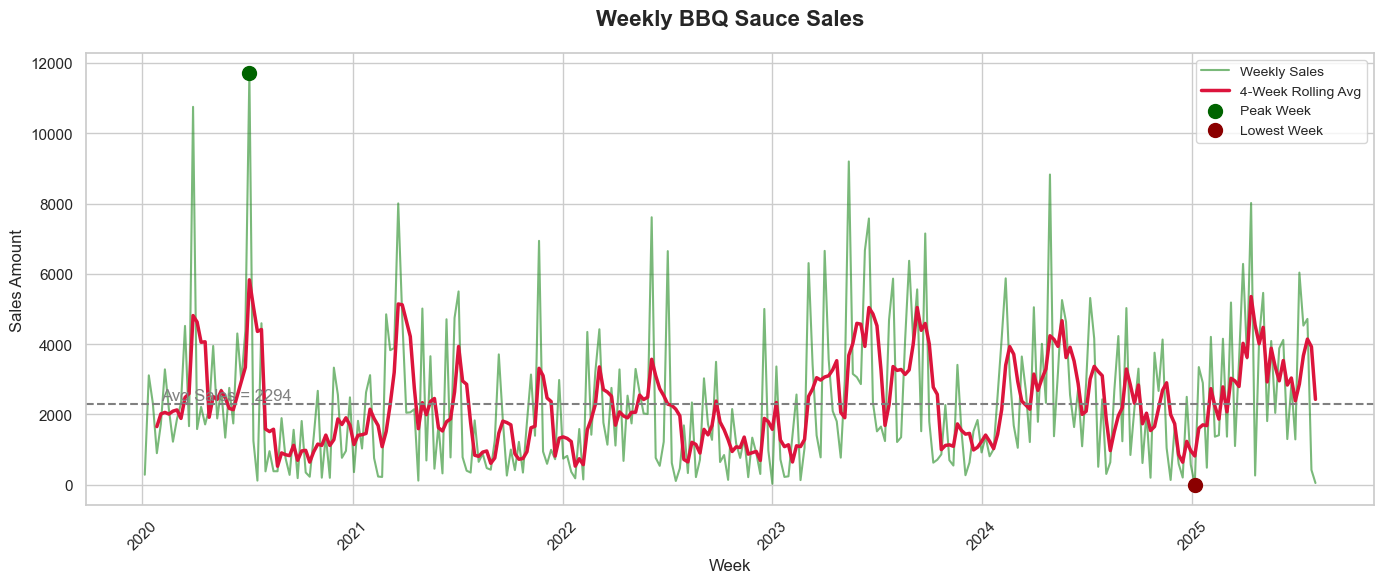

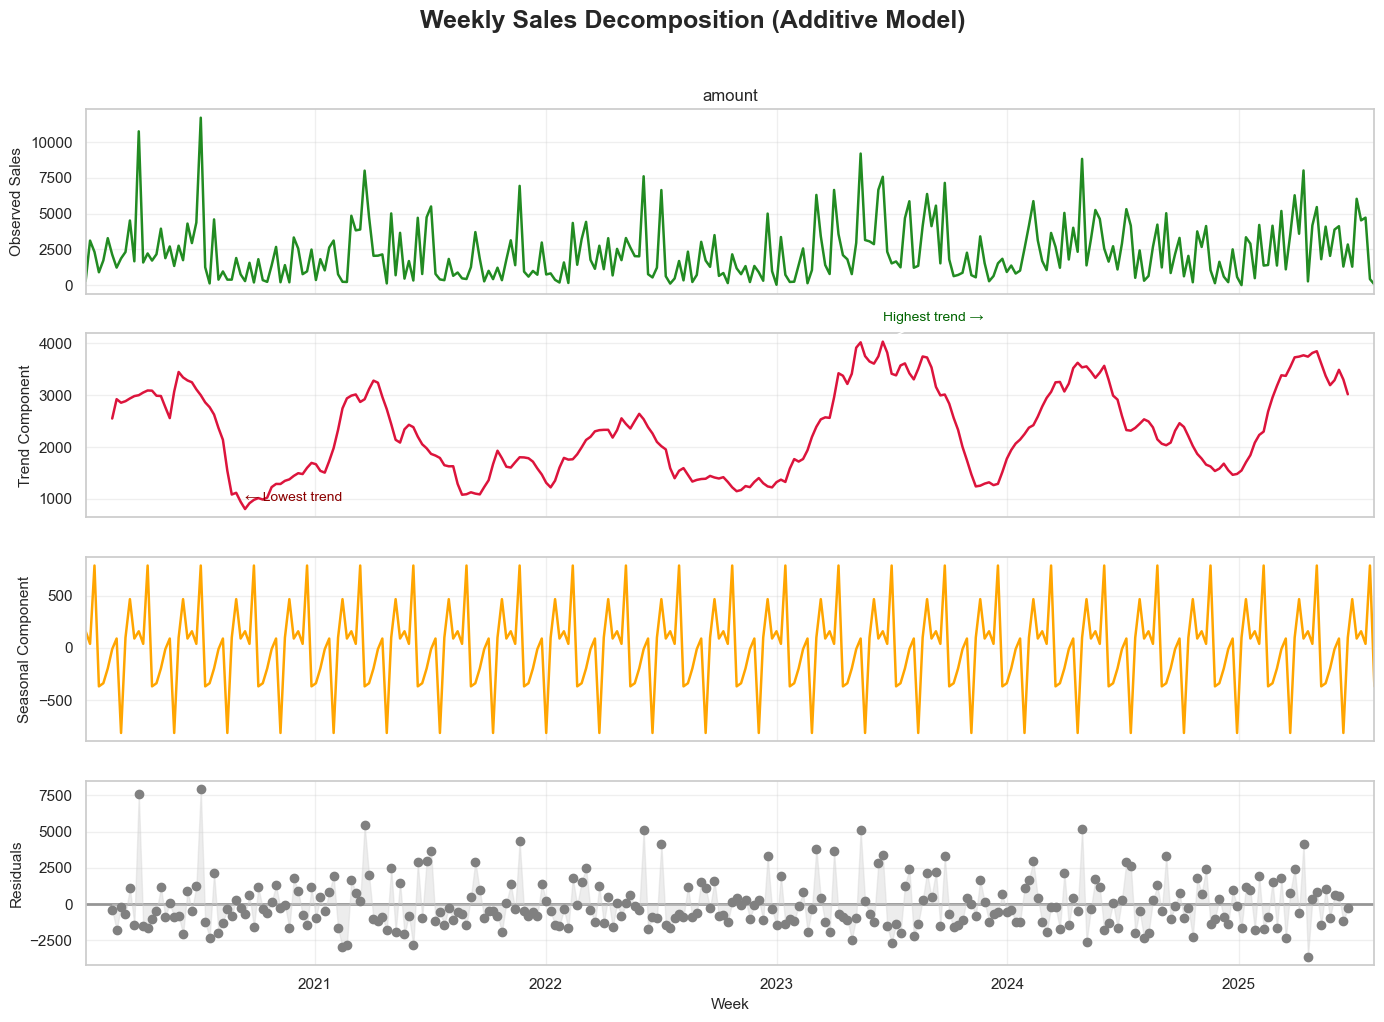

In [175]:
# 1. Weekly Sales Aggregation

weekly = data['amount'].resample('W').sum()  # sum sales per week

# Set seaborn style for polished visuals
sns.set_style("whitegrid")
plt.figure(figsize=(14,6))

# Plot weekly sales with trend line
plt.plot(weekly.index, weekly, color='forestgreen', alpha=0.6, label='Weekly Sales')
plt.plot(weekly.index, weekly.rolling(4).mean(), color='crimson', linewidth=2.5, label='4-Week Rolling Avg')

# Highlight max/min points
max_week = weekly.idxmax()
min_week = weekly.idxmin()
plt.scatter(max_week, weekly.max(), color='darkgreen', s=100, zorder=5, label='Peak Week')
plt.scatter(min_week, weekly.min(), color='darkred', s=100, zorder=5, label='Lowest Week')

# Mean line for reference
mean_weekly = weekly.mean()
plt.axhline(y=mean_weekly, color='gray', linestyle='--', linewidth=1.5)
plt.text(weekly.index[4], mean_weekly + mean_weekly*0.05, f"Avg Sales = {mean_weekly:.0f}", color='gray')

# Titles, labels, and legend
plt.title('Weekly BBQ Sauce Sales', fontsize=16, weight='bold', pad=20)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Sales Amount', fontsize=12)
plt.legend(frameon=True, facecolor='white', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. Weekly Sales Decomposition

weekly_decomp = seasonal_decompose(weekly, model='additive', period=12)  # ~12 weeks per quarter

fig = weekly_decomp.plot()
fig.set_size_inches(14,10)
fig.suptitle('Weekly Sales Decomposition (Additive Model)', fontsize=18, weight='bold', y=1.02)

# Customize y-labels
ylabels = ['Observed Sales', 'Trend Component', 'Seasonal Component', 'Residuals']
for ax, ylabel in zip(fig.axes, ylabels):
    ax.set_ylabel(ylabel, fontsize=11)

fig.axes[3].set_xlabel('Week', fontsize=11)

# Improve line styles
colors = ['forestgreen', 'crimson', 'orange', 'gray']
for ax, color in zip(fig.axes, colors):
    for line in ax.lines:
        line.set_color(color)
        line.set_linewidth(1.8)
    ax.grid(True, alpha=0.3)

# Shade residuals for clarity
fig.axes[3].fill_between(weekly.index, weekly_decomp.resid, color='lightgray', alpha=0.4)

# Annotate key trend points
trend_series = weekly_decomp.trend.dropna()
if not trend_series.empty:
    max_trend_date = trend_series.idxmax()
    min_trend_date = trend_series.idxmin()
    fig.axes[1].annotate('Highest trend →', xy=(max_trend_date, trend_series.max()), 
                         xytext=(max_trend_date, trend_series.max()*1.1),
                         arrowprops=dict(facecolor='darkgreen', arrowstyle='->'),
                         color='darkgreen', fontsize=10)
    fig.axes[1].annotate('← Lowest trend', xy=(min_trend_date, trend_series.min()), 
                         xytext=(min_trend_date, trend_series.min()*1.2),
                         arrowprops=dict(facecolor='darkred', arrowstyle='->'),
                         color='darkred', fontsize=10)

plt.tight_layout()
plt.show()


**The Weekly BBQ plot** shows strong weekly fluctuations in BBQ sauce sales, with a major sales peak in early 2020 and the lowest point around early 2025. The 4-week rolling average reveals recurring short-term cycles, suggesting periodic spikes in demand likely tied to seasonal or promotional events.

The decomposition plot shows that weekly BBQ sauce sales follow a clear seasonal pattern with consistent repeating cycles. The trend component indicates fluctuations over time, with the lowest point around 2021 and a strong upward movement reaching its peak in 2024. The seasonal component remains stable, reflecting predictable weekly buying habits. The residuals display a few sharp spikes, suggesting occasional irregular events or sudden shifts in demand.

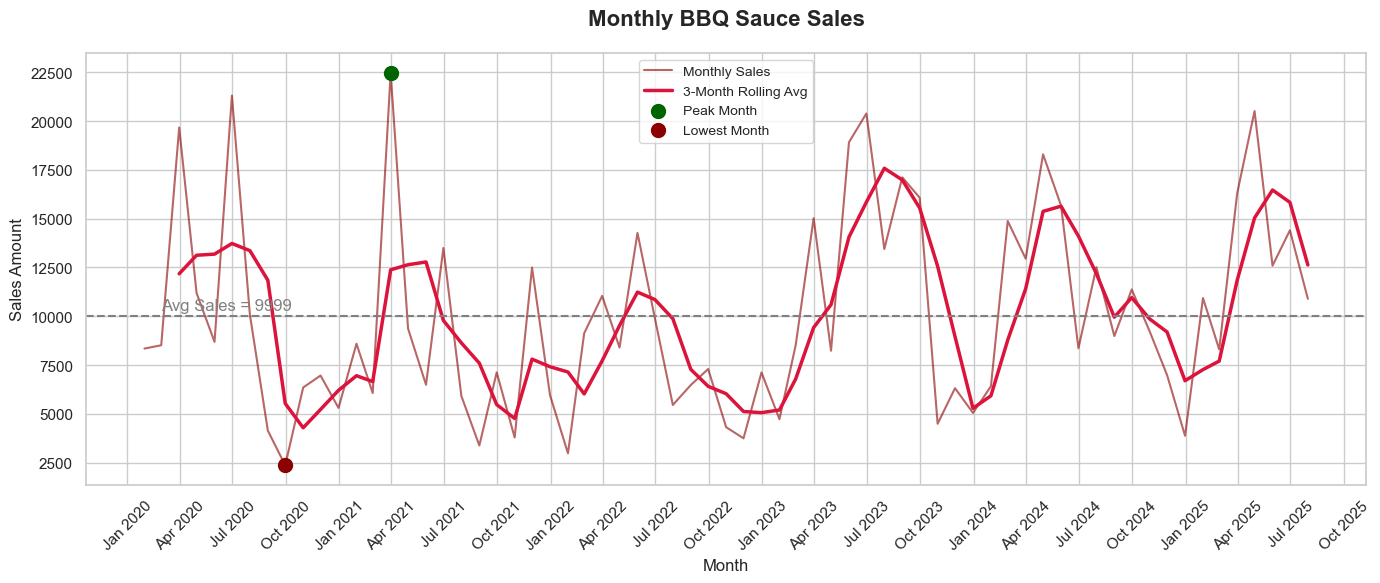

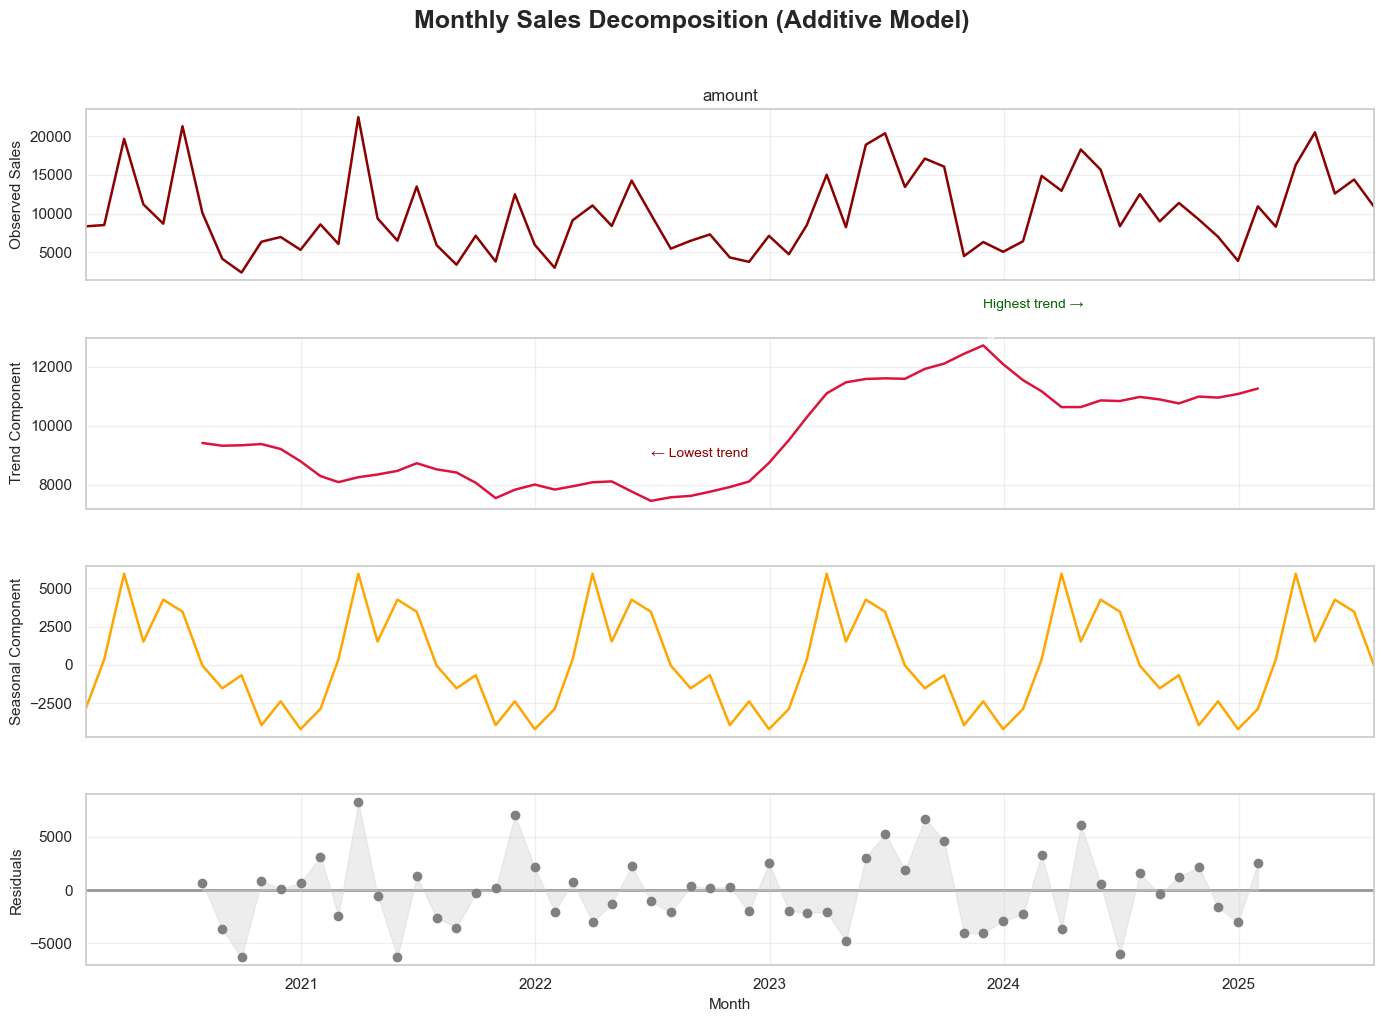

In [195]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Monthly Sales Aggregation

monthly = data['amount'].resample('M').sum()  # sum sales per month

# Seaborn style for polished visuals
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# Plot monthly sales with rolling trend line
plt.plot(monthly.index, monthly, color='darkred', alpha=0.6, label='Monthly Sales')
plt.plot(monthly.index, monthly.rolling(3).mean(), color='crimson', linewidth=2.5, label='3-Month Rolling Avg')

# Highlight max/min points
max_month = monthly.idxmax()
min_month = monthly.idxmin()
plt.scatter(max_month, monthly.max(), color='darkgreen', s=100, zorder=5, label='Peak Month')
plt.scatter(min_month, monthly.min(), color='darkred', s=100, zorder=5, label='Lowest Month')

# Mean line
mean_monthly = monthly.mean()
plt.axhline(y=mean_monthly, color='gray', linestyle='--', linewidth=1.5)
plt.text(monthly.index[1], mean_monthly + mean_monthly * 0.03, f"Avg Sales = {mean_monthly:.0f}", color='gray')

# Titles, labels, legend
plt.title('Monthly BBQ Sauce Sales', fontsize=16, weight='bold', pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales Amount', fontsize=12)
plt.legend(frameon=True, facecolor='white', fontsize=10)

# ---- New Part: Format X-axis with readable month-year labels ----
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan 2020
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # show every 3rd month
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# 2. Monthly Sales Decomposition

monthly_decomp = seasonal_decompose(monthly, model='additive', period=12)  # 12 months = 1 year

fig = monthly_decomp.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Monthly Sales Decomposition (Additive Model)', fontsize=18, weight='bold', y=1.02)

# Customize y-labels
ylabels = ['Observed Sales', 'Trend Component', 'Seasonal Component', 'Residuals']
for ax, ylabel in zip(fig.axes, ylabels):
    ax.set_ylabel(ylabel, fontsize=11)

fig.axes[3].set_xlabel('Month', fontsize=11)

# Improve line styles
colors = ['darkred', 'crimson', 'orange', 'gray']
for ax, color in zip(fig.axes, colors):
    for line in ax.lines:
        line.set_color(color)
        line.set_linewidth(1.8)
    ax.grid(True, alpha=0.3)

# Shade residuals
fig.axes[3].fill_between(monthly.index, monthly_decomp.resid, color='lightgray', alpha=0.4)

# Annotate key trend points
trend_series = monthly_decomp.trend.dropna()
if not trend_series.empty:
    max_trend_date = trend_series.idxmax()
    min_trend_date = trend_series.idxmin()
    fig.axes[1].annotate('Highest trend →', xy=(max_trend_date, trend_series.max()),
                         xytext=(max_trend_date, trend_series.max() * 1.1),
                         arrowprops=dict(facecolor='darkgreen', arrowstyle='->'),
                         color='darkgreen', fontsize=10)
    fig.axes[1].annotate('← Lowest trend', xy=(min_trend_date, trend_series.min()),
                         xytext=(min_trend_date, trend_series.min() * 1.2),
                         arrowprops=dict(facecolor='darkred', arrowstyle='->'),
                         color='darkred', fontsize=10)

plt.tight_layout()
plt.show()


The Monthly sales plot shows that sales consistently peak around mid-year, particularly in around July, suggesting strong seasonal demand during summer months. The 3-month rolling average confirms recurring mid-year spikes, likely linked to outdoor grilling and holiday activities.

The decomposition plot shows that monthly BBQ sauce sales follow a clear seasonal pattern, with consistent peaks likely occurring during summer months. The trend component indicates steady growth after 2022, reaching its highest point around 2024. The seasonal pattern remains stable over time, suggesting recurring buying habits. Residual spikes highlight occasional irregular sales surges beyond normal seasonal fluctuations.

# Box plots

In [3]:
sales_df   = r"barbecue_sauce_sales.csv"  
cli_df = r"climate_data.csv"  
sales   = pd.read_csv(sales_df)
climate = pd.read_csv(cli_df)
df = pd.merge(sales, climate, on="date", how="inner")
df["date"] = pd.to_datetime(df["date"])
df["dow"] = df["date"].dt.dayofweek
df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)

The boxplot is used to visualise the distribution and find outliers in the data. 
Q1 is the 25% of data,Q2 is the median and Q3 is the 75% 

So the key factors in the plot is the Box (IQR) which determines the Q1 to Q3 range of data, and the line inside is the median, whike the Whiskers are the range and cricles represent the outliers. 

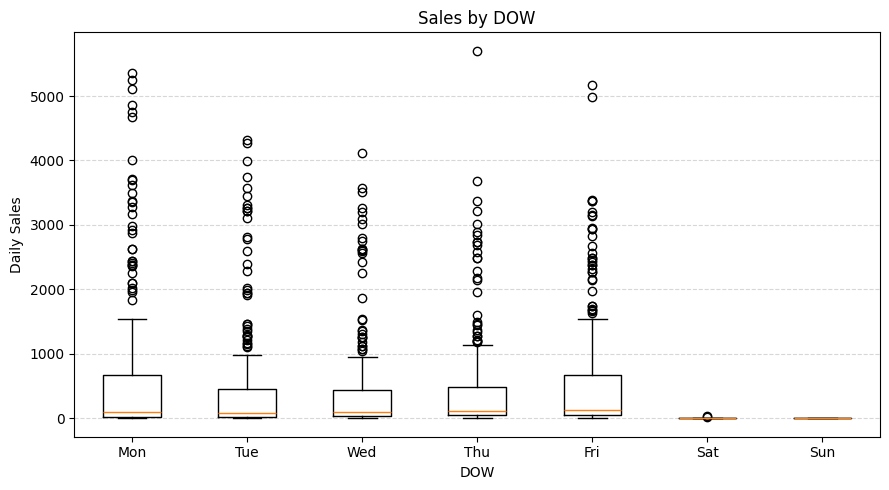

In [4]:
df["dow"] = df["date"].dt.dayofweek

box_data_dow = [df[df["dow"] == d]["amount"] for d in range(7)]
labels_dow = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plt.figure(figsize=(9, 5))
plt.boxplot(box_data_dow, labels=labels_dow, showfliers=True)
plt.title("Sales by DOW")
plt.xlabel("DOW")
plt.ylabel("Daily Sales")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Mon-fri the boxes are tall, which mean that there are higher sales to be precise monday and friday has more sales then followed by tues thurs and wed. 
mon and friday has more dispersion of data as weel as spread of data by seeing the lenght of whiskers 

Sat-sun the boxes are near to zero which means that it has near to zero sales or we could say sale on weekends are negligible. 

as the medians of the days lie in the same brackets we can say that the median is simialr 

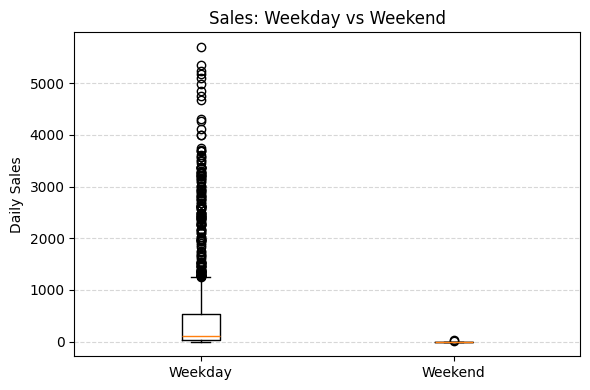

In [5]:
df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)

box_data_weekend = [
    df[df["is_weekend"] == 0]["amount"],  
    df[df["is_weekend"] == 1]["amount"],  
]
labels_weekend = ["Weekday", "Weekend"]

plt.figure(figsize=(6, 4))
plt.boxplot(box_data_weekend, labels=labels_weekend, showfliers=True)
plt.title("Sales: Weekday vs Weekend")
plt.ylabel("Daily Sales")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

weekday has wide spread which means regular slaes compare to weekend where the sale is zero. 

Very few outliers on the weeknedn which might indicate long weekednds. 

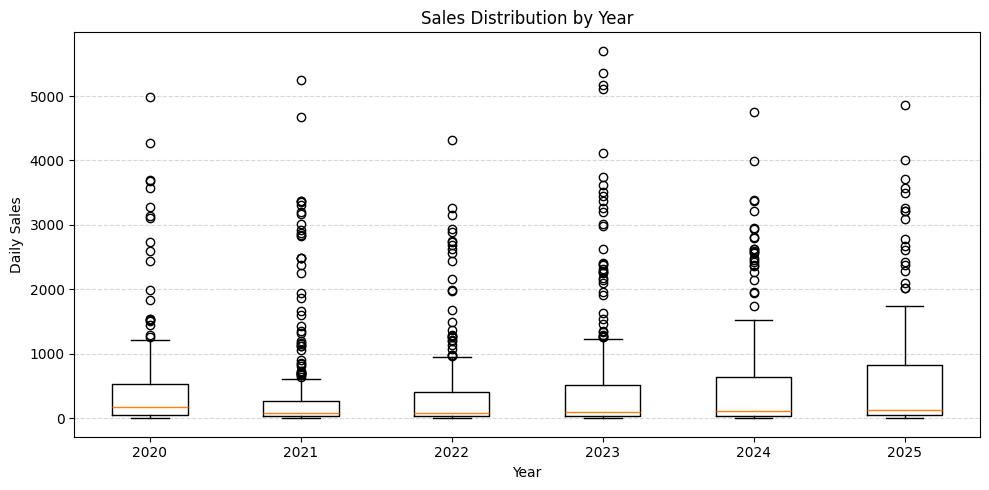

In [6]:
df["year"] = df["date"].dt.year

years = sorted(df["year"].unique())
box_data_year = [df[df["year"] == y]["amount"] for y in years]

plt.figure(figsize=(10, 5))
plt.boxplot(box_data_year, labels=years, showfliers=True)
plt.title("Sales Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Daily Sales")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

in the year 2020–2021 it had Lower median, tighter box which means lower average sales and less variation where as for 2022–2025 the sales gradually rising medians which directly corresponds to steady sales growth
Onto the Outliers, the circles become more frequent and extreme over years possibly due to seasonal peaks, or growth in market

Some invalid dates detected in climate_data:


,date,mean_temp_nationwide,min_temp_nationwide,max_temp_nationwide,mean_precipitation_mm_nationwide,min_precipitation_mm_nationwide,max_precipitation_mm_nationwide,mean_sun_hours_nationwide,min_sun_hours_nationwide,max_sun_hours_nationwide
6,NaT,5.22,3.1,7.3,0.22,0.0,1.0,1.166667,0.0,2.9
7,NaT,7.59,4.8,10.5,0.37,0.0,1.7,1.888889,0.0,7.5
8,NaT,8.98,4.9,11.7,0.28,0.0,1.5,4.355556,1.1,8.4
9,NaT,7.14,4.1,10.4,0.00,0.0,0.0,6.222222,4.8,7.1
10,NaT,5.93,2.9,8.6,1.09,0.0,4.9,4.544444,0.0,7.4



 Missing Data Report (after merge & cleaning):
amount       0
temp         4
precip       0
sun_hours    0
dtype: int64


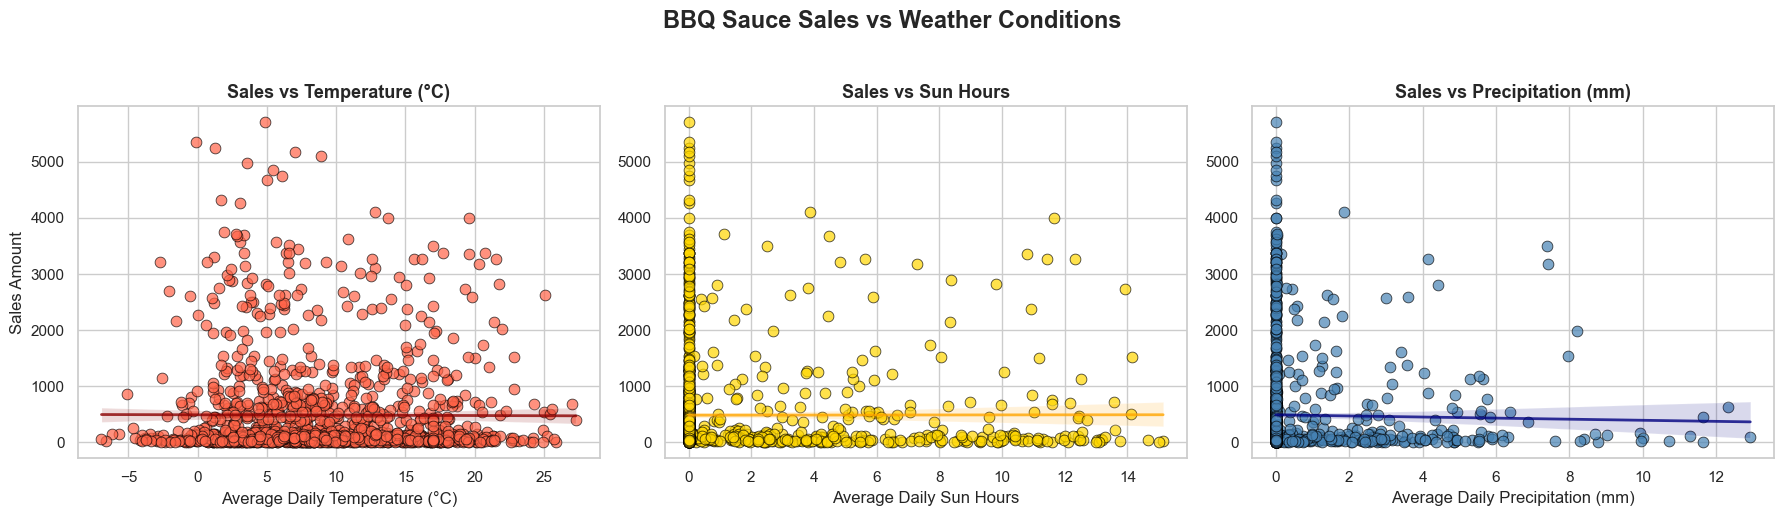


 Merge and Visualization Successful!
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1386 entries, 2020-01-03 to 2025-07-29
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   amount     1386 non-null   int64  
 1   temp       1382 non-null   float64
 2   precip     1386 non-null   float64
 3   sun_hours  1386 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 54.1 KB
None

 Preview of final merged data:


,amount,temp,precip,sun_hours
date,,,,
2020-01-03,285,NaN,0.00,0.000000
2020-01-06,627,NaN,0.00,0.000000
2020-01-07,241,NaN,0.00,0.000000
2020-01-08,356,NaN,0.00,0.000000
2020-01-09,877,14.76,1.23,3.722222


In [ ]:

# Merge Sales Data with Climate Data 

# Load and Prepare the Datasets
data = pd.read_csv("barbecue_sauce_sales.csv", parse_dates=['date'], date_format='%m/%d/%Y')
climate_data = pd.read_csv("climate_data.csv")

# Clean date column in climate data
climate_data['date'] = climate_data['date'].astype(str).str.strip()
climate_data['date'] = pd.to_datetime(climate_data['date'], dayfirst=True, errors='coerce')

# Check for invalid or NaT dates
if climate_data['date'].isna().sum() > 0:
    print("Some invalid dates detected in climate_data:")
    display(climate_data[climate_data['date'].isna()].head())

# Simplify column names for clarity
climate_data = climate_data.rename(columns={
    'mean_temp_nationwide': 'temp',
    'mean_precipitation_mm_nationwide': 'precip',
    'mean_sun_hours_nationwide': 'sun_hours'
})


# Prepare the Sales Data

# Ensure sales 'date' column is in datetime format
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    data.set_index('date', inplace=True)


# Merge Datasets (Left Join for Robustness)

merged = pd.merge(
    data,
    climate_data[['date', 'temp', 'precip', 'sun_hours']],
    on='date',
    how='left'
)
merged.set_index('date', inplace=True)


# Handle Missing Weather Data (Imputation)

# Interpolate smooth variables (temperature)
merged['temp'] = merged['temp'].interpolate(method='linear')

# Fill event-based features (rain & sun) with 0
merged['precip'].fillna(0, inplace=True)
merged['sun_hours'].fillna(0, inplace=True)


# Missingness Audit

print("\n Missing Data Report (after merge & cleaning):")
print(merged.isna().sum())


# Enhanced Side-by-Side Scatter Plots

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Sales vs Temperature 
sns.scatterplot(
    data=merged, x='temp', y='amount',
    ax=axes[0], color='tomato', alpha=0.7, s=60, edgecolor='black'
)
sns.regplot(
    data=merged, x='temp', y='amount',
    ax=axes[0], scatter=False, color='darkred',
    line_kws={'linewidth': 2, 'alpha': 0.8}
)
axes[0].set_title('Sales vs Temperature (°C)', fontsize=13, weight='bold')
axes[0].set_xlabel('Average Daily Temperature (°C)')
axes[0].set_ylabel('Sales Amount')

# Plot 2: Sales vs Sun Hours 
sns.scatterplot(
    data=merged, x='sun_hours', y='amount',
    ax=axes[1], color='gold', alpha=0.7, s=60, edgecolor='black'
)
sns.regplot(
    data=merged, x='sun_hours', y='amount',
    ax=axes[1], scatter=False, color='orange',
    line_kws={'linewidth': 2, 'alpha': 0.8}
)
axes[1].set_title('Sales vs Sun Hours', fontsize=13, weight='bold')
axes[1].set_xlabel('Average Daily Sun Hours')
axes[1].set_ylabel('')

# Plot 3: Sales vs Precipitation 
sns.scatterplot(
    data=merged, x='precip', y='amount',
    ax=axes[2], color='steelblue', alpha=0.7, s=60, edgecolor='black'
)
sns.regplot(
    data=merged, x='precip', y='amount',
    ax=axes[2], scatter=False, color='navy',
    line_kws={'linewidth': 2, 'alpha': 0.8}
)
axes[2].set_title('Sales vs Precipitation (mm)', fontsize=13, weight='bold')
axes[2].set_xlabel('Average Daily Precipitation (mm)')
axes[2].set_ylabel('')

# Final Styling 
fig.suptitle('BBQ Sauce Sales vs Weather Conditions', fontsize=17, weight='bold', y=1.03)
plt.tight_layout()
plt.show()


# Final Check

print("\n Merge and Visualization Successful!")
print(merged.info())
print("\n Preview of final merged data:")
display(merged.head())


Sales vs Temperature (left): Sales are scattered widely across all temperature levels, but there’s a slight concentration of higher sales around moderate temperatures (roughly 5–15°C). This suggests people tend to buy BBQ sauce more often during mild, comfortable weather, possibly reflecting outdoor cooking or grilling preferences.

Sales vs Sun Hours (middle): The sales remain relatively stable regardless of sunshine duration, though there are a few higher sales on days with more sun. This might mean sunny days encourage outdoor activities and thus more BBQ consumption, but the relationship isn’t strong overall.

Sales vs Precipitation (right): As rainfall increases, sales slightly drop, and most sales occur when precipitation is close to zero.

 **Pearson Correlation Matrix (Linear Relationship):**


,amount,temp,sun_hours,precip
amount,1.00,-0.00,0.00,-0.02
temp,-0.00,1.00,0.41,0.19
sun_hours,0.00,0.41,1.00,0.23
precip,-0.02,0.19,0.23,1.00



 **Spearman Correlation Matrix (Monotonic Relationship):**


,amount,temp,sun_hours,precip
amount,1.00,0.01,-0.03,-0.02
temp,0.01,1.00,0.27,0.19
sun_hours,-0.03,0.27,1.00,0.79
precip,-0.02,0.19,0.79,1.00



 **Correlation Significance (p-values)**
• Temp      : p-value = 0.8593  → Not Significant 
• Sun_hours : p-value = 0.9519  → Not Significant 
• Precip    : p-value = 0.5139  → Not Significant 


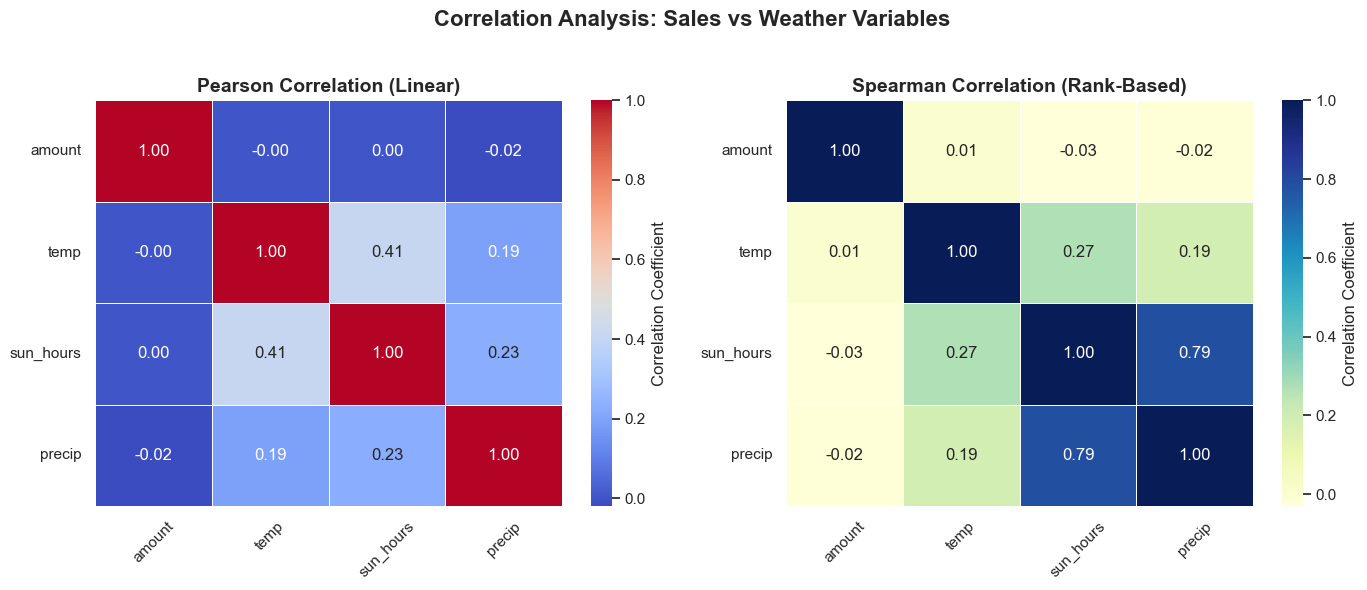


 **Automated Insights Summary:**
• Sales show a weak negative correlation with temp (-0.00, not statistically significant).
• Sales show a weak negative correlation with sun_hours (0.00, not statistically significant).
• Sales show a weak negative correlation with precip (-0.02, not statistically significant).


In [196]:

# Advanced Correlation Analysis: Sales vs Weather Variables

# Define variables of interest
features = ['temp', 'sun_hours', 'precip']
target = 'amount'

# Drop rows with NaNs in relevant columns
clean_data = merged[[target] + features].dropna()


# Compute Pearson and Spearman Correlations
pearson_corr = clean_data.corr(method='pearson').round(2)
spearman_corr = clean_data.corr(method='spearman').round(2)

print(" **Pearson Correlation Matrix (Linear Relationship):**")
display(pearson_corr)
print("\n **Spearman Correlation Matrix (Monotonic Relationship):**")
display(spearman_corr)

# Significance Testing (p-values)

print("\n **Correlation Significance (p-values)**")
p_values = {}
for col in features:
    r, p = pearsonr(clean_data[target], clean_data[col])
    p_values[col] = p
    print(f"• {col.capitalize():<10}: p-value = {p:.4f}  → {'Significant ' if p < 0.05 else 'Not Significant '}")


# Heatmap Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0], 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
axes[0].set_title("Pearson Correlation (Linear)", fontsize=14, weight='bold')

sns.heatmap(spearman_corr, annot=True, cmap='YlGnBu', fmt=".2f", ax=axes[1], 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
axes[1].set_title("Spearman Correlation (Rank-Based)", fontsize=14, weight='bold')

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.suptitle("Correlation Analysis: Sales vs Weather Variables", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Automated Insights Summary

print("\n **Automated Insights Summary:**")
for var in features:
    corr_value = pearson_corr.loc[target, var]
    significance = "significant" if p_values[var] < 0.05 else "not statistically significant"
    relation = "positive" if corr_value > 0 else "negative"
    strength = (
        "strong" if abs(corr_value) >= 0.7 else
        "moderate" if abs(corr_value) >= 0.4 else
        "weak"
    )
    print(f"• Sales show a {strength} {relation} correlation with {var} ({corr_value:.2f}, {significance}).")


# Save correlation results to CSV

pearson_corr.to_csv("correlation_results_pearson.csv", index=True)
spearman_corr.to_csv("correlation_results_spearman.csv", index=True)


The correlation heatmaps show that BBQ sauce sales have almost no linear or rank-based relationship with weather variables. Both Pearson and Spearman results confirm that temperature, sunlight, and precipitation have minimal influence on sales patterns, suggesting that other factors such as holidays or promotions play a stronger role in driving demand.

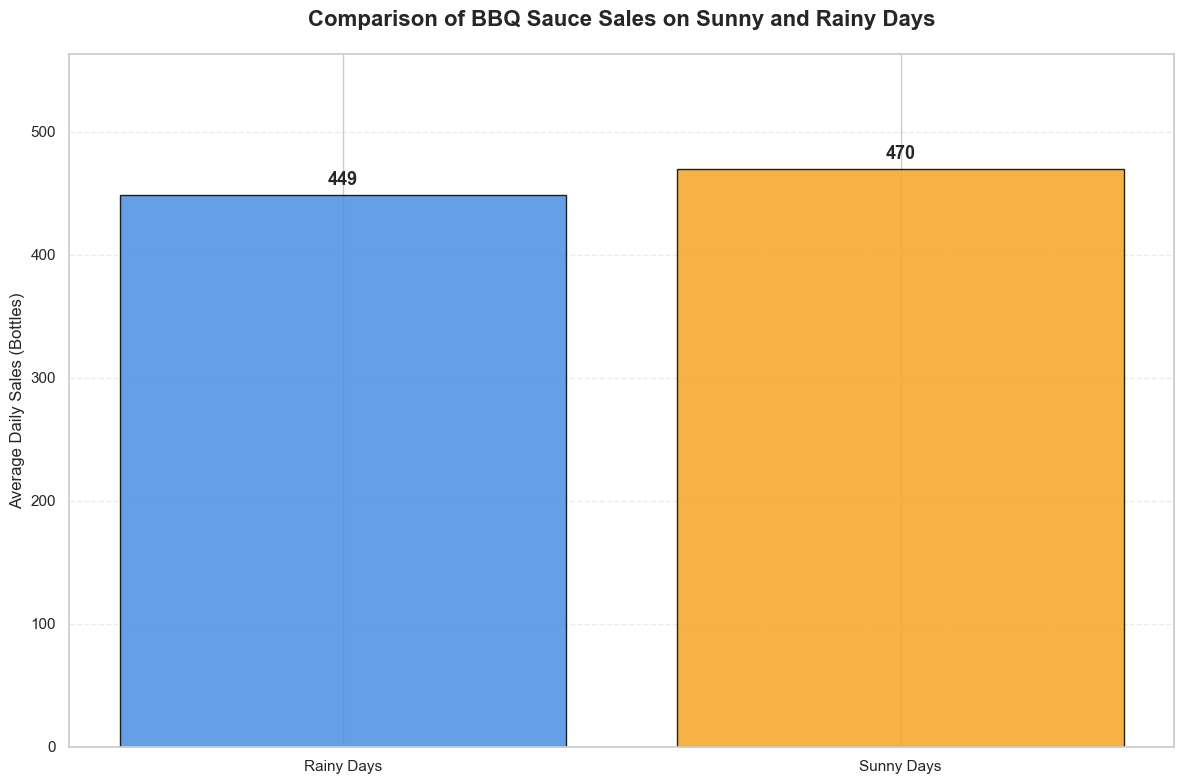

In [206]:

# Sunny vs Rainy Days: BBQ Sauce Sales Comparison

plt.figure(figsize=(12, 8))

# Create bar chart
bars = plt.bar(
    ['Rainy Days', 'Sunny Days'],
    [rainy_days['amount'].mean(), sunny_days['amount'].mean()],
    color=['#4A90E2', '#F5A623'],
    edgecolor='black',
    alpha=0.85
)

# Title and axis labels
plt.title('Comparison of BBQ Sauce Sales on Sunny and Rainy Days', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Average Daily Sales (Bottles)', fontsize=12)
plt.ylim(0, max(rainy_days['amount'].mean(), sunny_days['amount'].mean()) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bar values
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., height + 5,
        f'{height:.0f}', ha='center', va='bottom',
        fontsize=13, fontweight='bold'
    )

plt.tight_layout()
plt.show()


The bar chart shows that BBQ sauce sales are slightly higher on sunny days compared to rainy days. This suggests that pleasant weather encourages more outdoor cooking and grilling activities, leading to increased sauce purchases. The finding also indicates that weather-based promotions or marketing during sunny periods could effectively boost sales.